In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [19]:
dataset = pd.read_csv('../inputFile/modelInput/jlco0000st.csv')
dataset = dataset.drop(columns=['Time','FileName','Valence'])
test_dataset = pd.read_csv('../inputFile/modelInput/sentences/allFileCombineSentenceP.csv')
test_dataset = test_dataset.drop(columns=['Time','Valence'])

print(test_dataset.shape)
print(dataset.shape)

(1127890, 8)
(6708, 8)


In [20]:
# prepare data for lstms
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
values = dataset.values
test_values = test_dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
test_scaled = scaler.fit_transform(test_values)
# specify the number of lag hours
n_steps = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps, 1)
test_reframed = series_to_supervised(test_scaled, n_steps, 1)
print(reframed.shape)
print(test_reframed.shape)


(6705, 32)
(1127887, 32)


In [6]:
# split into train and test sets
values = reframed.values
n_train_steps = 6705 * 0.9 #90% of dataset
train = values[:n_train_steps, :]
test = values[n_train_steps:, :]

In [7]:
# split into input and outputs
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(1015101, 24) 1015101 (1015101,)


In [8]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1015101, 3, 8) (1015101,) (112786, 3, 8) (112786,)


Epoch 1/50
60/60 - 2s - loss: 0.2644 - val_loss: 0.1969
Epoch 2/50
60/60 - 0s - loss: 0.1890 - val_loss: 0.1335
Epoch 3/50
60/60 - 0s - loss: 0.1248 - val_loss: 0.1057
Epoch 4/50
60/60 - 0s - loss: 0.1082 - val_loss: 0.1007
Epoch 5/50
60/60 - 0s - loss: 0.1108 - val_loss: 0.0974
Epoch 6/50
60/60 - 0s - loss: 0.1017 - val_loss: 0.0956
Epoch 7/50
60/60 - 0s - loss: 0.1054 - val_loss: 0.0954
Epoch 8/50
60/60 - 0s - loss: 0.1031 - val_loss: 0.0943
Epoch 9/50
60/60 - 0s - loss: 0.0980 - val_loss: 0.0951
Epoch 10/50
60/60 - 1s - loss: 0.0929 - val_loss: 0.0921
Epoch 11/50
60/60 - 0s - loss: 0.0941 - val_loss: 0.0902
Epoch 12/50
60/60 - 0s - loss: 0.0956 - val_loss: 0.0891
Epoch 13/50
60/60 - 0s - loss: 0.0945 - val_loss: 0.0927
Epoch 14/50
60/60 - 0s - loss: 0.0915 - val_loss: 0.0849
Epoch 15/50
60/60 - 0s - loss: 0.0935 - val_loss: 0.0906
Epoch 16/50
60/60 - 0s - loss: 0.0881 - val_loss: 0.0817
Epoch 17/50
60/60 - 0s - loss: 0.0852 - val_loss: 0.0786
Epoch 18/50
60/60 - 0s - loss: 0.0841 - 

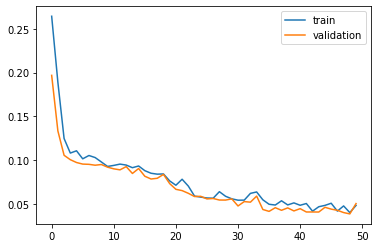

In [115]:
# design network
model = keras.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split = 0.2, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [110]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_steps*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.139


In [111]:
from sklearn.metrics import r2_score
r2_score(inv_y, inv_yhat)

0.8779480097785194

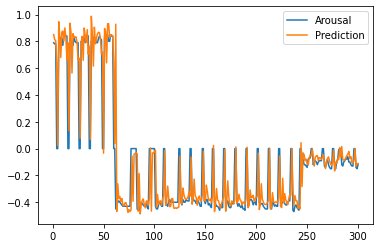

In [112]:
pred_test_list = [i for i in inv_yhat]
submission = pd.DataFrame({'Arousal' : inv_y, 'Prediction' : pred_test_list})
submission.loc[1:, ['Arousal', 'Prediction']][0:300].plot()
submission.to_csv('submission.csv', index=False)

In [113]:
correlation = submission.corr(method='pearson')
print(correlation)

             Arousal  Prediction
Arousal     1.000000    0.945041
Prediction  0.945041    1.000000


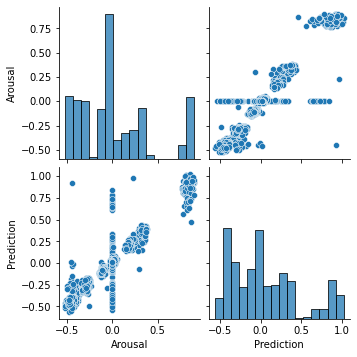

In [114]:
d0 = submission[['Arousal', 'Prediction']]
sns.pairplot(d0, kind="scatter")
plt.show()